In [ ]:
!pip -q install python-docx
import pandas as pd, numpy as np, matplotlib.pyplot as plt, datetime as dt, os
from matplotlib.backends.backend_pdf import PdfPages
from docx import Document
from docx.shared import Inches
import datetime as dt,os
from google.colab import files
uploaded=files.upload(); csv_name=list(uploaded.keys())[0]; print("Yüklenen dosya:",csv_name); df=pd.read_csv(csv_name); print(df.shape); df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 4.4 MB/s eta 0:00:00


Saving MFGEmployees4.csv to MFGEmployees4.csv
Yüklenen dosya: MFGEmployees4.csv
(8336, 13)


,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores


In [ ]:
# ==== 2. ŞEMA & KOLON KONTROL ====
print("Sütunlar:", df.columns.tolist())
print("\nBilgi:")
print(df.info())

print("\nÖrnek 5 satır:")
display(df.head())

print("\nKısa istatistikler (sayısal):")
display(df.describe())


Sütunlar: ['EmployeeNumber', 'Surname', 'GivenName', 'Gender', 'City', 'JobTitle', 'DepartmentName', 'StoreLocation', 'Division', 'Age', 'LengthService', 'AbsentHours', 'BusinessUnit']

Bilgi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8336 entries, 0 to 8335
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EmployeeNumber  8336 non-null   int64  
 1   Surname         8336 non-null   object 
 2   GivenName       8336 non-null   object 
 3   Gender          8336 non-null   object 
 4   City            8336 non-null   object 
 5   JobTitle        8336 non-null   object 
 6   DepartmentName  8336 non-null   object 
 7   StoreLocation   8336 non-null   object 
 8   Division        8336 non-null   object 
 9   Age             8336 non-null   float64
 10  LengthService   8336 non-null   float64
 11  AbsentHours     8336 non-null   float64
 12  BusinessUnit    8336 non-null   object 
dtypes: float64(3), int64

,EmployeeNumber,Surname,GivenName,Gender,City,JobTitle,DepartmentName,StoreLocation,Division,Age,LengthService,AbsentHours,BusinessUnit
0,1,Gutierrez,Molly,F,Burnaby,Baker,Bakery,Burnaby,Stores,32.028816,6.018478,36.577306,Stores
1,2,Hardwick,Stephen,M,Courtenay,Baker,Bakery,Nanaimo,Stores,40.320902,5.532445,30.165072,Stores
2,3,Delgado,Chester,M,Richmond,Baker,Bakery,Richmond,Stores,48.822047,4.389973,83.807798,Stores
3,4,Simon,Irene,F,Victoria,Baker,Bakery,Victoria,Stores,44.599357,3.081736,70.020165,Stores
4,5,Delvalle,Edward,M,New Westminster,Baker,Bakery,New Westminster,Stores,35.697876,3.619091,0.000000,Stores



Kısa istatistikler (sayısal):


,EmployeeNumber,Age,LengthService,AbsentHours
count,8336.000000,8336.000000,8336.000000,8336.000000
mean,4168.500000,42.007086,4.782910,61.283978
std,2406.540255,9.939798,2.462990,49.038365
min,1.000000,3.504743,0.012098,0.000000
25%,2084.750000,35.298748,3.575892,19.127590
50%,4168.500000,42.114924,4.600248,56.005808
75%,6252.250000,48.666943,5.623922,94.284692
max,8336.000000,77.938003,43.735239,272.530123


In [ ]:
# ==== 3. BASİT TEMİZLİK ====
df_clean = df.copy()

# Age değerleri çok küçük olanları NaN yap (ör: <16)
df_clean.loc[df_clean['Age'] < 16, 'Age'] = np.nan

# Aykırı değerleri çok uçsa kırp (winsorize mantığı – isteğe bağlı)
df_clean['Age'] = df_clean['Age'].clip(lower=16, upper=80)
df_clean['LengthService'] = df_clean['LengthService'].clip(lower=0, upper=df_clean['LengthService'].quantile(0.99))
df_clean['AbsentHours'] = df_clean['AbsentHours'].clip(lower=0, upper=df_clean['AbsentHours'].quantile(0.99))

print("Temizlik sonrası özet:")
display(df_clean[['Age','LengthService','AbsentHours']].describe())


Temizlik sonrası özet:


,Age,LengthService,AbsentHours
count,8292.000000,8336.000000,8336.000000
mean,42.161246,4.697673,61.087898
std,9.735676,1.807529,48.426780
min,16.129028,0.012098,0.000000
25%,35.447338,3.575892,19.127590
50%,42.177983,4.600248,56.005808
75%,48.698413,5.623922,94.284692
max,77.938003,13.678978,195.948001


In [ ]:
# ==== 4. KATEGORİK & SAYISAL LİSTELER ====
cat_cols = ['Gender','City','JobTitle','DepartmentName','StoreLocation','Division','BusinessUnit','Surname','GivenName']
num_cols = ['EmployeeNumber','Age','LengthService','AbsentHours']

print("Kategorik:", cat_cols)
print("Sayısal:", num_cols)


Kategorik: ['Gender', 'City', 'JobTitle', 'DepartmentName', 'StoreLocation', 'Division', 'BusinessUnit', 'Surname', 'GivenName']
Sayısal: ['EmployeeNumber', 'Age', 'LengthService', 'AbsentHours']


In [ ]:
# ==== 5.a CİNSİYETE GÖRE DEVAMSIZLIK ====
gender_abs = df_clean.groupby('Gender')['AbsentHours'].agg(['mean','sum','count']).sort_values('mean', ascending=False)
display(gender_abs)


,mean,sum,count
Gender,,,
F,66.312592,273207.880150,4120
M,55.982171,236020.833554,4216


In [ ]:
# ==== 5.b ŞEHRE GÖRE DEVAMSIZLIK (TOP 15) ====
city_abs = (df_clean.groupby('City')['AbsentHours']
            .sum()
            .sort_values(ascending=False)
            .head(15))
display(city_abs)


,AbsentHours
City,
Vancouver,106020.054551
Victoria,40918.628971
New Westminster,33164.696398
Burnaby,20585.826103
Surrey,17358.670215
Richmond,14873.313210
Prince George,11226.231851
Nanaimo,9859.073102
Kamloops,9232.282540


In [ ]:
# ==== 5.c DEPARTMANA GÖRE ORTALAMA DEVAMSIZLIK (TOP 15) ====
dept_abs = (df_clean.groupby('DepartmentName')['AbsentHours']
            .mean()
            .sort_values(ascending=False)
            .head(15))
display(dept_abs)


,AbsentHours
DepartmentName,
Processed Foods,63.224852
Recruitment,63.009726
Customer Service,62.787127
Dairy,62.762526
Training,61.834916
Bakery,61.214132
Employee Records,60.160239
Meats,59.535129
Produce,59.295817


In [ ]:
# ==== 5.d İŞ UNVANINA GÖRE TOPLAM DEVAMSIZLIK (TOP 15) ====
job_abs = (df_clean.groupby('JobTitle')['AbsentHours']
           .sum()
           .sort_values(ascending=False)
           .head(15))
display(job_abs)


,AbsentHours
JobTitle,
Cashier,107028.417134
Dairy Person,94892.825166
Meat Cutter,88010.307446
Baker,86284.765552
Produce Clerk,67174.508150
Shelf Stocker,45314.846021
Bakery Manager,2414.511271
Meats Manager,2125.878280
Customer Service Manager,2032.821602


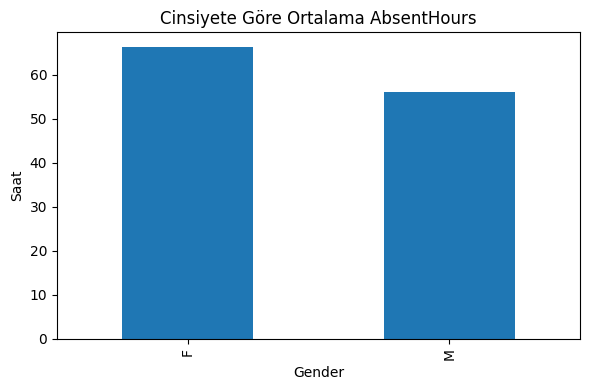

In [ ]:
# ==== 6.a CİNSİYETE GÖRE ORTALAMA DEVAMSIZLIK (BAR) ====
plot_series = df_clean.groupby('Gender')['AbsentHours'].mean().sort_values(ascending=False)

plt.figure(figsize=(6,4))
plot_series.plot(kind='bar')
plt.title('Cinsiyete Göre Ortalama AbsentHours')
plt.ylabel('Saat')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()


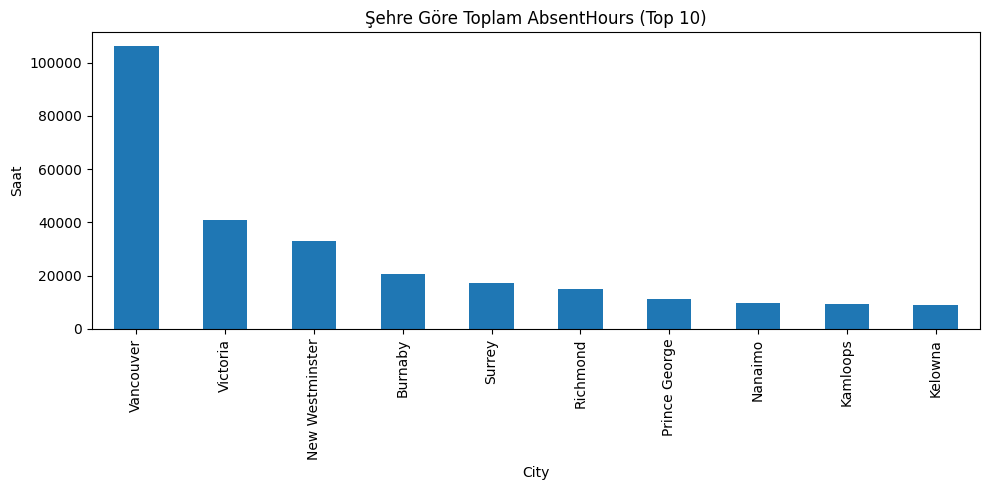

In [ ]:
# ==== 6.b ŞEHRE GÖRE TOPLAM DEVAMSIZLIK (TOP 10) ====
plot_series = (df_clean.groupby('City')['AbsentHours']
               .sum()
               .sort_values(ascending=False)
               .head(10))

plt.figure(figsize=(10,5))
plot_series.plot(kind='bar')
plt.title('Şehre Göre Toplam AbsentHours (Top 10)')
plt.ylabel('Saat')
plt.xlabel('City')
plt.tight_layout()
plt.show()


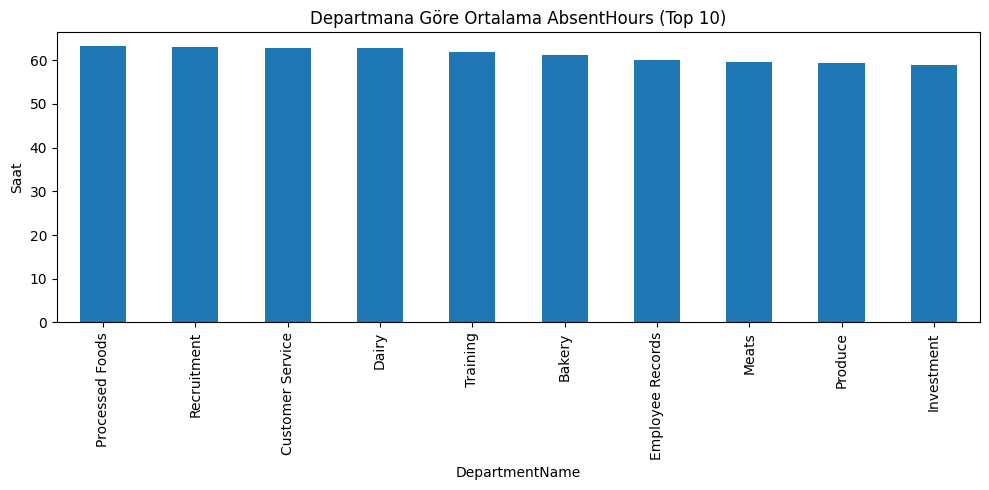

In [ ]:
# ==== 6.c DEPARTMANA GÖRE ORTALAMA DEVAMSIZLIK (TOP 10) ====
plot_series = (df_clean.groupby('DepartmentName')['AbsentHours']
               .mean()
               .sort_values(ascending=False)
               .head(10))

plt.figure(figsize=(10,5))
plot_series.plot(kind='bar')
plt.title('Departmana Göre Ortalama AbsentHours (Top 10)')
plt.ylabel('Saat')
plt.xlabel('DepartmentName')
plt.tight_layout()
plt.show()


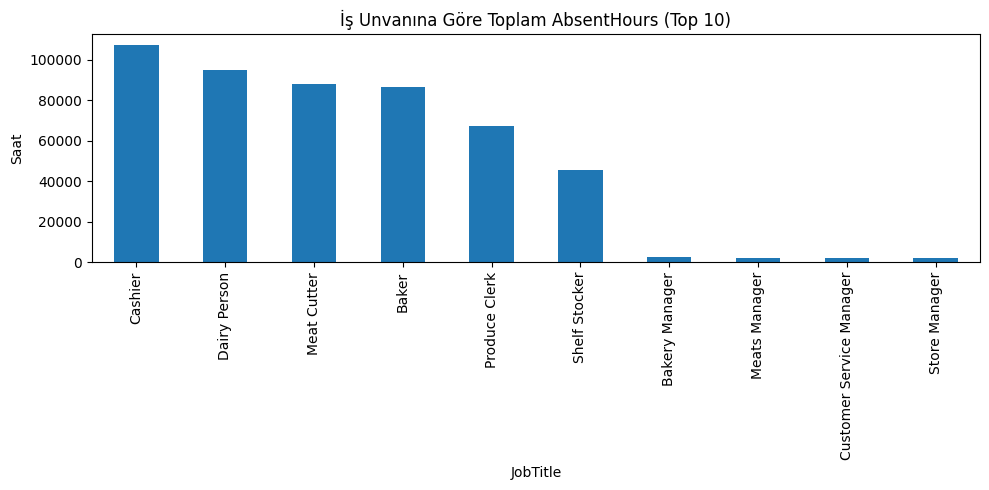

In [ ]:
# ==== 6.d İŞ UNVANINA GÖRE TOPLAM DEVAMSIZLIK (TOP 10) ====
plot_series = (df_clean.groupby('JobTitle')['AbsentHours']
               .sum()
               .sort_values(ascending=False)
               .head(10))

plt.figure(figsize=(10,5))
plot_series.plot(kind='bar')
plt.title('İş Unvanına Göre Toplam AbsentHours (Top 10)')
plt.ylabel('Saat')
plt.xlabel('JobTitle')
plt.tight_layout()
plt.show()


,Age,LengthService,AbsentHours
Age,1.000000,0.031120,0.834035
LengthService,0.031120,1.000000,-0.034486
AbsentHours,0.834035,-0.034486,1.000000


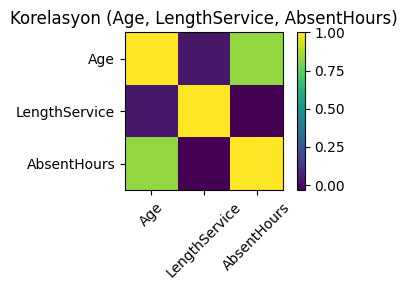

In [ ]:
# ==== 7. KORELASYON MATRİSİ ====
corr = df_clean[['Age','LengthService','AbsentHours']].corr()
display(corr)

plt.figure(figsize=(4,3))
plt.imshow(corr, interpolation='nearest')
plt.title('Korelasyon (Age, LengthService, AbsentHours)')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()


In [ ]:
# ==== 8. ÖZET RAPOR ====
summary = df_clean[['Age','LengthService','AbsentHours']].agg(['min','median','mean','max']).T
summary.columns = ['min','median','mean','max']
display(summary)


,min,median,mean,max
Age,16.129028,42.177983,42.161246,77.938003
LengthService,0.012098,4.600248,4.697673,13.678978
AbsentHours,0.000000,56.005808,61.087898,195.948001


In [ ]:
# ==== 9. YARDIMCI FONKSİYONLAR ====
def top_n_sum(col, n=10):
    return (df_clean.groupby(col)['AbsentHours']
            .sum()
            .sort_values(ascending=False)
            .head(n))

def top_n_mean(col, n=10):
    return (df_clean.groupby(col)['AbsentHours']
            .mean()
            .sort_values(ascending=False)
            .head(n))

print(top_n_sum('City', 10))
print()
print(top_n_mean('DepartmentName', 10))


City
Vancouver          106020.054551
Victoria            40918.628971
New Westminster     33164.696398
Burnaby             20585.826103
Surrey              17358.670215
Richmond            14873.313210
Prince George       11226.231851
Nanaimo              9859.073102
Kamloops             9232.282540
Kelowna              9027.050949
Name: AbsentHours, dtype: float64

DepartmentName
Processed Foods     63.224852
Recruitment         63.009726
Customer Service    62.787127
Dairy               62.762526
Training            61.834916
Bakery              61.214132
Employee Records    60.160239
Meats               59.535129
Produce             59.295817
Investment          58.981066
Name: AbsentHours, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

def top_n_sum_plot(col,n=10):
    data=df_clean.groupby(col)['AbsentHours'].sum().sort_values(ascending=False).head(n)
    data.plot(kind='bar',figsize=(8,4),title=f"Toplam AbsentHours by {col} (Top {n})")
    plt.ylabel("Toplam Saat")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.show()

def top_n_mean_plot(col,n=10):
    data=df_clean.groupby(col)['AbsentHours'].mean().sort_values(ascending=False).head(n)
    data.plot(kind='bar',figsize=(8,4),title=f"Ortalama AbsentHours by {col} (Top {n})")
    plt.ylabel("Ortalama Saat")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.show()


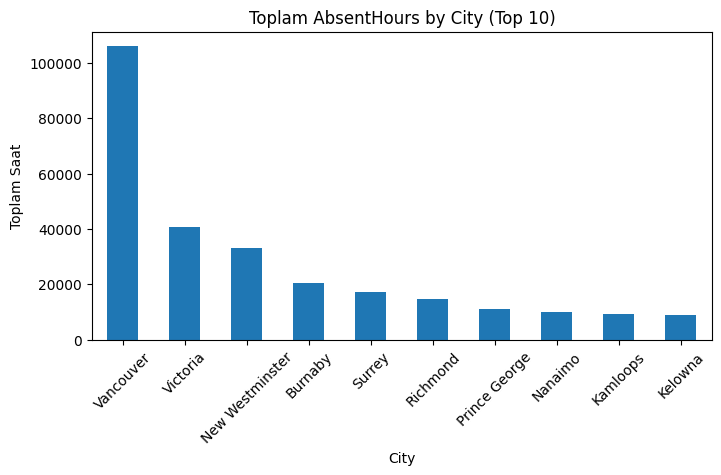

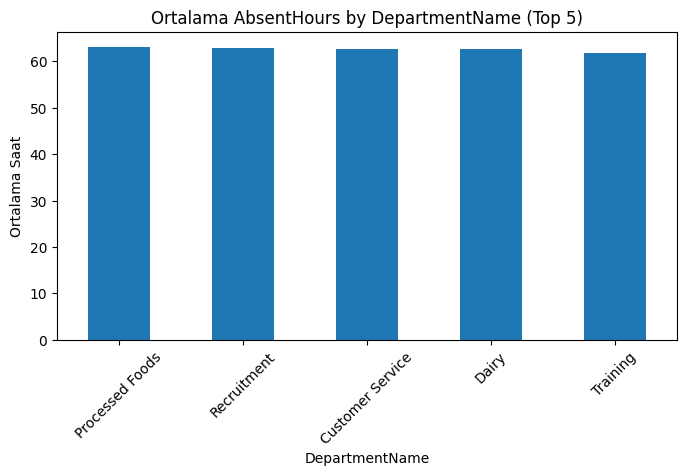

In [ ]:
top_n_sum_plot("City",10)          # Şehirlere göre toplam devamsızlık
print()
top_n_mean_plot("DepartmentName",5) # Departmanlara göre ortalama devamsızlık


Otomatik Rapor

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from docx import Document
from docx.shared import Inches
import matplotlib.pyplot as plt,datetime as dt,os

# kolon-listesi
charts=[("City","sum",10),("DepartmentName","mean",10),("JobTitle","sum",10),("Gender","mean",2),("StoreLocation","sum",10),("Division","sum",10),("BusinessUnit","mean",10)]

# zaman damgaları ve dosya adları
stamp=dt.datetime.now().strftime("%Y-%m-%d_%H-%M")
pdf_name=f"Absenteeism_Report_{stamp}.pdf"
docx_name=f"Absenteeism_Report_{stamp}.docx"
img_files=[]

# yardımcı: seri üret (sum/mean) ve figür çiz
def make_series(df,col,mode,topn):
    if col not in df.columns: return None
    s=df.groupby(col)['AbsentHours'].sum().sort_values(ascending=False).head(topn) if mode=="sum" else df.groupby(col)['AbsentHours'].mean().sort_values(ascending=False).head(topn)
    return s if not s.empty else None
def plot_series(s,title,xlabel):
    fig=plt.figure(figsize=(10,4)); s.plot(kind="bar"); plt.title(title); plt.ylabel("Saat"); plt.xlabel(xlabel); plt.xticks(rotation=45); plt.tight_layout(); return fig

# === PDF üret (kapak + grafikler) ===
with PdfPages(pdf_name) as pdf:
    cover=plt.figure(figsize=(8.27,11.69)); plt.text(0.5,0.62,"Employee Absenteeism Raporu",ha="center",va="center",fontsize=22); plt.text(0.5,0.55,f"Tarih: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}",ha="center",va="center",fontsize=12); plt.axis("off"); pdf.savefig(cover,bbox_inches="tight"); plt.close(cover)
    for col,mode,topn in charts:
        s=make_series(df_clean,col,mode,topn)
        if s is None: continue
        title=f"{'Toplam' if mode=='sum' else 'Ortalama'} AbsentHours by {col} (Top {topn})"
        fig=plot_series(s,title,col)
        img=f"{col}_{mode}_{stamp}.png"
        fig.savefig(img,dpi=150,bbox_inches="tight")
        pdf.savefig(fig,bbox_inches="tight")
        plt.close(fig)
        img_files.append((img,title))

# === Word üret ===
doc=Document()
doc.add_heading("Employee Absenteeism – Otomatik Rapor",0)
doc.add_paragraph(f"Oluşturma tarihi: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}")
doc.add_paragraph("Bu rapor df_clean veri çerçevesinden üretilmiştir. Grafikler AbsentHours metriklerini farklı kategorik değişkenlere göre özetler.")
for img,title in img_files:
    if os.path.exists(img):
        doc.add_heading(title,level=2)
        doc.add_picture(img,width=Inches(6))
doc.save(docx_name)

print("✓ PDF kaydedildi:",pdf_name)
print("✓ Word kaydedildi:",docx_name)
print("✓ Görseller:",[i for i,_ in img_files])



✓ PDF kaydedildi: Absenteeism_Report_2025-08-28_06-07.pdf
✓ Word kaydedildi: Absenteeism_Report_2025-08-28_06-07.docx
✓ Görseller: ['City_sum_2025-08-28_06-07.png', 'DepartmentName_mean_2025-08-28_06-07.png', 'JobTitle_sum_2025-08-28_06-07.png', 'Gender_mean_2025-08-28_06-07.png', 'StoreLocation_sum_2025-08-28_06-07.png', 'Division_sum_2025-08-28_06-07.png', 'BusinessUnit_mean_2025-08-28_06-07.png']


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt,datetime as dt,os
stamp=dt.datetime.now().strftime("%Y-%m-%d_%H-%M")
pdf_name=f"Absenteeism_Report_{stamp}.pdf"
with PdfPages(pdf_name) as pdf:
    # Kapak sayfası (PDF'in oluştuğunu garanti eder)
    fig=plt.figure(figsize=(8.27,11.69)); plt.text(0.5,0.6,"Employee Absenteeism Raporu",ha="center",va="center",fontsize=20); plt.text(0.5,0.5,f"Tarih: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}",ha="center",va="center",fontsize=12); plt.axis("off"); pdf.savefig(fig,bbox_inches="tight"); plt.close(fig)
    # Örnek grafikler (kolon varsa ekler)
    charts=[("City","sum",10),("DepartmentName","mean",10),("JobTitle","sum",10),("Gender","mean",2)]
    for col,mode,topn in charts:
        if col not in df_clean.columns: continue
        if mode=="sum":
            s=df_clean.groupby(col)['AbsentHours'].sum().sort_values(ascending=False).head(topn)
        else:
            s=df_clean.groupby(col)['AbsentHours'].mean().sort_values(ascending=False).head(topn)
        if s.empty: continue
        fig=plt.figure(figsize=(10,4)); s.plot(kind="bar"); plt.title(f"{'Toplam' if mode=='sum' else 'Ortalama'} AbsentHours by {col} (Top {topn})"); plt.ylabel("Saat"); plt.xlabel(col); plt.xticks(rotation=45); plt.tight_layout(); pdf.savefig(fig,bbox_inches="tight"); plt.close(fig)
# Oluştu mu? Boyutunu ve dizini yazdır
exists=os.path.exists(pdf_name); size=os.path.getsize(pdf_name) if exists else 0
print("✓ PDF adı:",pdf_name)
print("✓ Var mı?",exists,"| Boyut (bayt):",size)
print("Dizindeki dosyalar:",os.listdir("/content"))



✓ PDF adı: Absenteeism_Report_2025-08-28_06-07.pdf
✓ Var mı? True | Boyut (bayt): 24724
Dizindeki dosyalar: ['.config', 'Gender_mean_2025-08-28_06-07.png', 'Division_sum_2025-08-28_06-07.png', 'Absenteeism_Report_2025-08-28_06-07.docx', 'MFGEmployees4.csv', 'Absenteeism_Report_2025-08-28_06-07.pdf', 'City_sum_2025-08-28_06-07.png', 'BusinessUnit_mean_2025-08-28_06-07.png', 'StoreLocation_sum_2025-08-28_06-07.png', 'JobTitle_sum_2025-08-28_06-07.png', 'DepartmentName_mean_2025-08-28_06-07.png', 'sample_data']


In [ ]:
import os
os.listdir("/content")


['.config',
 'Gender_mean_2025-08-28_06-07.png',
 'Division_sum_2025-08-28_06-07.png',
 'Absenteeism_Report_2025-08-28_06-07.docx',
 'MFGEmployees4.csv',
 'Absenteeism_Report_2025-08-28_06-07.pdf',
 'City_sum_2025-08-28_06-07.png',
 'BusinessUnit_mean_2025-08-28_06-07.png',
 'StoreLocation_sum_2025-08-28_06-07.png',
 'JobTitle_sum_2025-08-28_06-07.png',
 'DepartmentName_mean_2025-08-28_06-07.png',
 'sample_data']

In [ ]:
from google.colab import files
files.download("Absenteeism_Report_2025-08-28_06-07.pdf")
files.download("Absenteeism_Report_2025-08-28_06-07.docx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

DepartmentName + City + JobTitle için KPI tabloları

In [ ]:
!pip -q install python-pptx
import matplotlib.pyplot as plt,pandas as pd,numpy as np,datetime as dt,os
from pptx import Presentation
from pptx.util import Inches
stamp=dt.datetime.now().strftime("%Y-%m-%d_%H-%M"); pptx_name=f"Absenteeism_Summary_{stamp}.pptx"; prs=Presentation()
def make_series(df,col,mode,topn):
    if col not in df.columns or 'AbsentHours' not in df.columns: return None
    s=df.groupby(col)['AbsentHours'].sum().sort_values(ascending=False).head(topn) if mode=="sum" else df.groupby(col)['AbsentHours'].mean().sort_values(ascending=False).head(topn)
    return s if not s.empty else None
def plot_series(s,title,xlabel,filename):
    fig=plt.figure(figsize=(10,4)); s.plot(kind="bar"); plt.title(title); plt.ylabel("Saat"); plt.xlabel(xlabel); plt.xticks(rotation=45); plt.tight_layout(); fig.savefig(filename,dpi=150,bbox_inches="tight"); plt.close(fig); return filename
def kpi_table(df,group_col,topn=10):
    if group_col not in df.columns or 'AbsentHours' not in df.columns: return None
    g=df.groupby(group_col)['AbsentHours']; out=pd.DataFrame({"N":g.count(),"Sum":g.sum(),"Mean":g.mean()}).sort_values("Sum",ascending=False).head(topn); out["%Contribution"]=(out["Sum"]/out["Sum"].sum()*100).round(1); return out.reset_index()
title_slide=prs.slides.add_slide(prs.slide_layouts[0]); title_slide.shapes.title.text="Employee Absenteeism – Özet Sunum"; title_slide.placeholders[1].text=f"Tarih: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}"
meth_slide=prs.slides.add_slide(prs.slide_layouts[1]); meth_slide.shapes.title.text="Yöntem (Kısa)"; tx=meth_slide.shapes.placeholders[1].text_frame; tx.text="• Kaynak: df_clean (CSV/Excel), Python pandas"; p=tx.add_paragraph(); p.text="• Temizlik: Age<16 düzeltildi; uç değerler clip"; p=tx.add_paragraph(); p.text="• Analiz: AbsentHours toplam/ortalama; City/Department/Job/Gender"; p=tx.add_paragraph(); p.text="• Çıktı: Grafikler + PDF/DOCX/PPTX"
charts=[("City","sum",10),("DepartmentName","mean",10),("JobTitle","sum",10),("Gender","mean",2)]; imgs=[]
for col,mode,topn in charts:
    s=make_series(df_clean,col,mode,topn)
    if s is None: continue
    title=f"{'Toplam' if mode=='sum' else 'Ortalama'} AbsentHours by {col} (Top {topn})"; fp=f"{col}_{mode}_{stamp}.png"; imgs.append((plot_series(s,title,col,fp),title))
for fp,title in imgs:
    sl=prs.slides.add_slide(prs.slide_layouts[5]); sl.shapes.title.text=title; sl.shapes.add_picture(fp,Inches(0.7),Inches(1.8),width=Inches(8.3))
for group_col in ["DepartmentName","City","JobTitle"]:
    kpi=kpi_table(df_clean,group_col,10)
    if kpi is None or kpi.empty: continue
    sl=prs.slides.add_slide(prs.slide_layouts[5]); sl.shapes.title.text=f"KPI Tablosu – İlk 10 {group_col}"
    rows,cols=kpi.shape; rows=rows+1
    x,y,w,h=Inches(0.5),Inches(1.6),Inches(9.0),Inches(4.5); tbl=sl.shapes.add_table(rows,cols,x,y,w,h).table
    for j,col in enumerate(kpi.columns): tbl.cell(0,j).text=str(col)
    for r in range(1,rows):
        for c in range(cols): tbl.cell(r,c).text=str(kpi.iloc[r-1,c])
prs.save(pptx_name); print("✓ PPTX kaydedildi:",pptx_name)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 1.7 MB/s eta 0:00:00
✓ PPTX kaydedildi: Absenteeism_Summary_2025-08-28_06-08.pptx


In [ ]:
from google.colab import files
files.download(pptx_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hedef Değişkeni, Özellik Mühendisliği, Veri Hazırlık

In [ ]:
import numpy as np,pandas as pd
dfm=df_clean.copy()
thr=dfm['AbsentHours'].quantile(0.75)
dfm['HighAbsence']=(dfm['AbsentHours']>=thr).astype(int)
dfm['TenureBin']=pd.cut(dfm['LengthService'],bins=[0,1,3,5,100],labels=['0-1','1-3','3-5','5+'])
dfm['CityTop']=dfm['City'].where(dfm['City'].isin(dfm['City'].value_counts().head(10).index),'Other')
dfm['JobTop']=dfm['JobTitle'].where(dfm['JobTitle'].isin(dfm['JobTitle'].value_counts().head(10).index),'Other')
feat_cat=['Gender','DepartmentName','CityTop','JobTop','TenureBin','BusinessUnit','Division','StoreLocation']
feat_num=['Age','LengthService']
use_cols=feat_cat+feat_num+['HighAbsence']
dfm=dfm[use_cols].dropna()


özellik mühendisliği + modelleme + değerlendirme + önem listesi + risk özeti

Veri şekli: (8336, 13)
Kategorik: ['Gender', 'DepartmentName', 'CityTop', 'JobTop', 'BusinessUnit', 'Division', 'StoreLocation', 'TenureBin']
Sayısal: ['Age', 'LengthService']
NaN sayıları (ilk 10):
 Age               44
Gender             0
DepartmentName     0
CityTop            0
BusinessUnit       0
JobTop             0
Division           0
StoreLocation      0
TenureBin          0
LengthService      0
dtype: int64

=== Logistic ===
              precision    recall  f1-score   support

           0      0.948     0.851     0.897      1251
           1      0.659     0.861     0.746       417

    accuracy                          0.854      1668
   macro avg      0.804     0.856     0.822      1668
weighted avg      0.876     0.854     0.860      1668

ROC-AUC: 0.9355910954689485


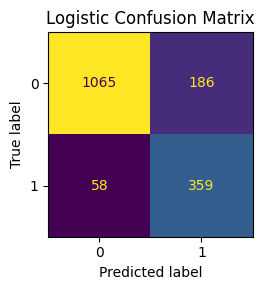


=== RandomForest ===
              precision    recall  f1-score   support

           0      0.893     0.934     0.913      1251
           1      0.769     0.664     0.713       417

    accuracy                          0.866      1668
   macro avg      0.831     0.799     0.813      1668
weighted avg      0.862     0.866     0.863      1668

ROC-AUC: 0.9141300868178359


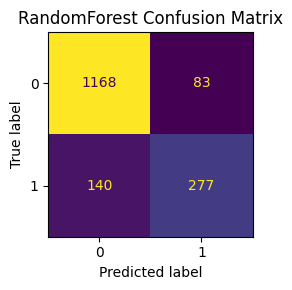


Özellik Önemi (Top 15):
Age 0.6265
LengthService 0.1389
TenureBin_3-5 0.0102
TenureBin_5+ 0.009
Gender_F 0.0081
CityTop_Other 0.008
Gender_M 0.0077
TenureBin_1-3 0.0065
StoreLocation_Nanaimo 0.006
StoreLocation_Victoria 0.0052
StoreLocation_Kelowna 0.005
StoreLocation_Kamloops 0.0048
JobTop_Meat Cutter 0.0048
DepartmentName_Bakery 0.0048
JobTop_Baker 0.0047

Departman Bazlı HighRiskRate (Top 15):
                         HighRiskRate    N
DepartmentName                           
Processed Foods             0.178808  151
Dairy                       0.144231  312
Customer Service            0.139053  338
Bakery                      0.137184  277
Produce                     0.125954  262
Meats                       0.122034  295
Accounts Payable            0.000000    1
Accounting                  0.000000    1
Compensation                0.000000    3
Accounts Receiveable        0.000000    5
Executive                   0.000000    3
Employee Records            0.000000    2
Audit     

In [ ]:
# == 0) Gerekli kütüphaneler ==
import pandas as pd,numpy as np,matplotlib.pyplot as plt,os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay

# == 1) Veriyi al: df_clean varsa onu kullan; yoksa yükle ve temel temizlik yap ==
try:
    df_clean
except NameError:
    try:
        from google.colab import files
        uploaded=files.upload(); csv_name=list(uploaded.keys())[0]; df=pd.read_csv(csv_name)
    except:
        raise SystemExit("CSV yüklenmedi. Colab kullanıyorsan dosyanı yükleyip tekrar çalıştır.")
    df_clean=df.copy()
    if 'Age' in df_clean.columns: df_clean.loc[df_clean['Age']<16,'Age']=np.nan; df_clean['Age']=df_clean['Age'].clip(lower=16,upper=80)
    if 'LengthService' in df_clean.columns: df_clean['LengthService']=df_clean['LengthService'].clip(lower=0,upper=df_clean['LengthService'].quantile(0.99))
    if 'AbsentHours' in df_clean.columns: df_clean['AbsentHours']=df_clean['AbsentHours'].clip(lower=0,upper=df_clean['AbsentHours'].quantile(0.99))
print("Veri şekli:",df_clean.shape)

# == 2) Hedef ve özellik mühendisliği ==
dfm=df_clean.copy()
if 'AbsentHours' not in dfm.columns: raise SystemExit("AbsentHours kolonu bulunamadı.")
thr=dfm['AbsentHours'].quantile(0.75)
dfm['HighAbsence']=(dfm['AbsentHours']>=thr).astype(int)
if 'LengthService' in dfm.columns and 'TenureBin' not in dfm.columns: dfm['TenureBin']=pd.cut(dfm['LengthService'],bins=[0,1,3,5,100],labels=['0-1','1-3','3-5','5+'])
if 'City' in dfm.columns: top_c=dfm['City'].value_counts().head(10).index; dfm['CityTop']=dfm['City'].where(dfm['City'].isin(top_c),'Other')
if 'JobTitle' in dfm.columns: top_j=dfm['JobTitle'].value_counts().head(10).index; dfm['JobTop']=dfm['JobTitle'].where(dfm['JobTitle'].isin(top_j),'Other')

# == 3) Özellik listelerini mevcut kolonlara göre otomatik kur ==
feat_cat=[c for c in ['Gender','DepartmentName','CityTop','JobTop','BusinessUnit','Division','StoreLocation','TenureBin'] if c in dfm.columns]
feat_num=[c for c in ['Age','LengthService'] if c in dfm.columns]
if len(feat_cat)+len(feat_num)==0: raise SystemExit("Kullanılabilir özellik bulunamadı.")
X=dfm[feat_cat+feat_num]; y=dfm['HighAbsence']
print("Kategorik:",feat_cat); print("Sayısal:",feat_num); print("NaN sayıları (ilk 10):\n",X.isna().sum().sort_values(ascending=False).head(10))

# == 4) Train/Test ayır ==
Xtr,Xte,Ytr,Yte=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# == 5) Ön işleme + Modeller (imputer zorunlu!) ==
pre=ColumnTransformer([
    ('cat',Pipeline([('imp',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore'))]),feat_cat),
    ('num',Pipeline([('imp',SimpleImputer(strategy='median')),('sc',StandardScaler())]),feat_num)
])
logit=Pipeline([('pre',pre),('clf',LogisticRegression(max_iter=1000,class_weight='balanced'))])
rf=Pipeline([('pre',pre),('clf',RandomForestClassifier(n_estimators=300,random_state=42,class_weight='balanced'))])

# == 6) Eğitim + Değerlendirme ==
for name,model in [('Logistic',logit),('RandomForest',rf)]:
    model.fit(Xtr,Ytr)
    p=model.predict(Xte); proba=model.predict_proba(Xte)[:,1]
    print(f"\n=== {name} ==="); print(classification_report(Yte,p,digits=3)); print("ROC-AUC:",roc_auc_score(Yte,proba))
    cm=confusion_matrix(Yte,p,labels=[0,1]); disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1]); fig,ax=plt.subplots(figsize=(3.5,3)); disp.plot(ax=ax,colorbar=False); plt.title(f"{name} Confusion Matrix"); plt.tight_layout(); plt.show()

# == 7) En iyi modeli seç (burada RF) ve özellik önemi yazdır ==
best=rf; best.fit(Xtr,Ytr)
try:
    ohe=best.named_steps['pre'].named_transformers_['cat'].named_steps['ohe']
    importances=best.named_steps['clf'].feature_importances_
    cat_names=ohe.get_feature_names_out(feat_cat) if len(feat_cat)>0 else np.array([])
    num_names=np.array(feat_num)
    feat_names=np.concatenate([cat_names,num_names]) if len(num_names)>0 else cat_names
    idx=np.argsort(importances)[::-1][:15]
    print("\nÖzellik Önemi (Top 15):")
    for i in idx: print(str(feat_names[i]),round(float(importances[i]),4))
except Exception as e:
    print("Özellik önemi çıkarılırken sorun:",e)

# == 8) Risk skoru ve departman özeti ==
proba=best.predict_proba(Xte)[:,1]
thr_score=0.7
risk_lbl=np.where(proba>=thr_score,'High','Low')
out=Xte.copy(); out['True']=Yte.values; out['RiskScore']=proba; out['RiskLabel']=risk_lbl
if 'DepartmentName' in out.columns:
    dept=out.assign(isHigh=(out['RiskLabel']=='High').astype(int)).groupby('DepartmentName')['isHigh'].agg(['mean','count']).sort_values('mean',ascending=False).head(15).rename(columns={'mean':'HighRiskRate','count':'N'})
    print("\nDepartman Bazlı HighRiskRate (Top 15):\n",dept)
else:
    print("\nDepartmentName kolonu yok, departman özeti atlandı.")
print("\nBitti ✔️")


**hiperparametre ayarı, eşik (threshold) optimizasyonu, ROC/PR grafikleri, model artefaktlarını kaydetme ve skorlanmış veri dışa aktarma**

RandomForest için Grid Search (5-kat CV, ROC-AUC)

In [ ]:
from sklearn.model_selection import StratifiedKFold,GridSearchCV
param_grid={"clf__n_estimators":[200,400],"clf__max_depth":[None,10,20],"clf__min_samples_split":[2,5],"clf__min_samples_leaf":[1,2]}
cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
gs=GridSearchCV(rf,param_grid,scoring="roc_auc",cv=cv,n_jobs=-1,verbose=1)
gs.fit(Xtr,Ytr)
best=gs.best_estimator_
print("Best params:",gs.best_params_); print("CV ROC-AUC:",gs.best_score_)
p=best.predict(Xte); proba=best.predict_proba(Xte)[:,1]
from sklearn.metrics import classification_report,roc_auc_score
print(classification_report(Yte,p,digits=3)); print("Test ROC-AUC:",roc_auc_score(Yte,proba))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best params: {'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}
CV ROC-AUC: 0.917145706494509
              precision    recall  f1-score   support

           0      0.944     0.861     0.901      1251
           1      0.670     0.847     0.748       417

    accuracy                          0.857      1668
   macro avg      0.807     0.854     0.824      1668
weighted avg      0.875     0.857     0.862      1668

Test ROC-AUC: 0.9264645837287006


Eşik (threshold) optimizasyonu: Youden J ve En İyi F1

In [ ]:
from sklearn.metrics import precision_recall_curve,roc_curve
fpr,tpr,thr=roc_curve(Yte,proba)
youden=tpr-fpr; thr_youden=float(thr[youden.argmax()])
prec,rec,thr2=precision_recall_curve(Yte,proba); f1=2*prec*rec/(prec+rec+1e-9)
thr_f1=float(thr2[f1[:-1].argmax()]) if len(thr2)>0 else 0.5
print("Best thr (Youden):",round(thr_youden,3),"| Best thr (F1):",round(thr_f1,3))
thr_use=thr_f1
pred_opt=(proba>=thr_use).astype(int)
print(classification_report(Yte,pred_opt,digits=3))


Best thr (Youden): 0.429 | Best thr (F1): 0.611
              precision    recall  f1-score   support

           0      0.926     0.910     0.918      1251
           1      0.743     0.782     0.762       417

    accuracy                          0.878      1668
   macro avg      0.834     0.846     0.840      1668
weighted avg      0.880     0.878     0.879      1668



ROC ve Precision-Recall grafikleri

<Figure size 500x400 with 0 Axes>

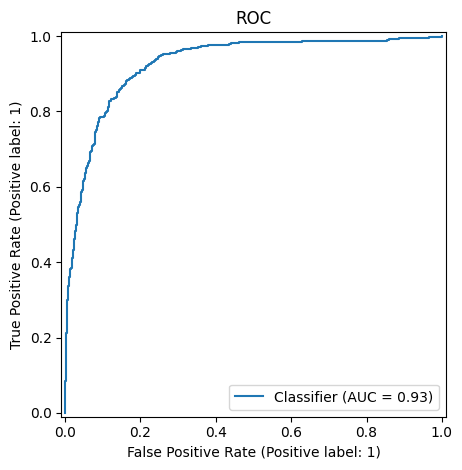

<Figure size 500x400 with 0 Axes>

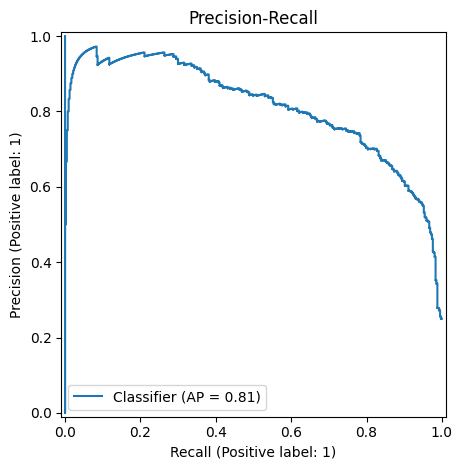

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay,PrecisionRecallDisplay
fig=plt.figure(figsize=(5,4)); RocCurveDisplay.from_predictions(Yte,proba); plt.title("ROC"); plt.tight_layout(); plt.savefig("roc.png",dpi=150,bbox_inches="tight"); plt.show()
fig=plt.figure(figsize=(5,4)); PrecisionRecallDisplay.from_predictions(Yte,proba); plt.title("Precision-Recall"); plt.tight_layout(); plt.savefig("pr.png",dpi=150,bbox_inches="tight"); plt.show()


Özellik önemi ve CSV’ye dökme

In [ ]:
import numpy as np,pandas as pd
ohe=best.named_steps['pre'].named_transformers_['cat'].named_steps['ohe'] if 'cat' in best.named_steps['pre'].named_transformers_ else None
cat_names=ohe.get_feature_names_out(feat_cat) if ohe is not None and len(feat_cat)>0 else np.array([])
num_names=np.array(feat_num)
feat_names=np.concatenate([cat_names,num_names]) if len(num_names)>0 else cat_names
imp=best.named_steps['clf'].feature_importances_
idx=np.argsort(imp)[::-1][:20]
feat_imp=pd.DataFrame({"feature":feat_names[idx],"importance":imp[idx]})
print(feat_imp); feat_imp.to_csv("feature_importance_top20.csv",index=False)


                            feature  importance
0                               Age    0.761880
1                     LengthService    0.068988
2                          Gender_F    0.011321
3                          Gender_M    0.010620
4                     TenureBin_3-5    0.007349
5                      TenureBin_5+    0.006510
6                     CityTop_Other    0.004968
7                     TenureBin_1-3    0.004475
8                JobTop_Meat Cutter    0.003614
9              DepartmentName_Meats    0.003557
10            DepartmentName_Bakery    0.003553
11                     JobTop_Baker    0.003366
12  DepartmentName_Customer Service    0.003340
13                   JobTop_Cashier    0.003212
14           StoreLocation_Victoria    0.003136
15           DepartmentName_Produce    0.003122
16              JobTop_Dairy Person    0.003068
17             DepartmentName_Dairy    0.003055
18             JobTop_Produce Clerk    0.002980
19            StoreLocation_Nanaimo    0

Skorlanmış test seti ve departman özeti

In [ ]:
scored=Xte.copy(); scored["True"]=Yte.values; scored["Proba"]=proba; scored["Pred_opt"]=(proba>=thr_use).astype(int)
scored.to_csv("scored_test.csv",index=False)
if "DepartmentName" in scored.columns:
    dept=scored.assign(isHigh=(scored["Pred_opt"]==1).astype(int)).groupby("DepartmentName")["isHigh"].agg(["mean","count"]).sort_values("mean",ascending=False).rename(columns={"mean":"HighRiskRate","count":"N"})
    print(dept.head(15)); dept.reset_index().to_csv("dept_highrisk_summary.csv",index=False)


                        HighRiskRate    N
DepartmentName                           
Processed Foods             0.337748  151
Customer Service            0.286982  338
Dairy                       0.275641  312
Produce                     0.251908  262
Meats                       0.244068  295
Bakery                      0.241877  277
Accounts Payable            0.000000    1
Accounting                  0.000000    1
Compensation                0.000000    3
Accounts Receiveable        0.000000    5
Executive                   0.000000    3
Employee Records            0.000000    2
Audit                       0.000000    3
Information Technology      0.000000    3
Labor Relations             0.000000    2


Modeli ve metadata’yı deployment için kaydet

In [ ]:
import joblib,json
joblib.dump(best,"model_rf.pkl")
meta={"feat_cat":feat_cat,"feat_num":feat_num,"thr_use":thr_use}
with open("model_meta.json","w") as f: json.dump(meta,f)
print("Kaydedildi: model_rf.pkl, model_meta.json")


Kaydedildi: model_rf.pkl, model_meta.json


YENİ EKLENEN METRİKLERİ OTOMATİK RAPORLAMA

In [ ]:
from docx import Document
from docx.shared import Inches
from matplotlib.backends.backend_pdf import PdfPages
import datetime as dt,os,numpy as np,pandas as pd,matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

stamp=dt.datetime.now().strftime("%Y-%m-%d_%H-%M")
pdf_name=f"Absenteeism_ExtendedReport_{stamp}.pdf"
docx_name=f"Absenteeism_ExtendedReport_{stamp}.docx"

# Güvenlik: gerekli dosyalar var mı?
need_imgs=[("roc.png","ROC Curve"),("pr.png","Precision-Recall Curve")]
missing=[p for p,_ in need_imgs if not os.path.exists(p)]
if missing: print("Uyarı: Eksik görseller:",missing,"(ROC/PR adımlarını önce çalıştırın)")

# == 1) PDF: ROC ve PR'ı ekle ==
with PdfPages(pdf_name) as pdf:
    for img,_ in need_imgs:
        if os.path.exists(img):
            fig=plt.figure(); ax=fig.add_subplot(111); ax.axis("off"); ax.imshow(plt.imread(img)); pdf.savefig(fig,bbox_inches="tight"); plt.close(fig)
    # Confusion Matrix'i de yeniden üretip PDF'e koy
    fig,ax=plt.subplots(figsize=(3.5,3)); ConfusionMatrixDisplay.from_predictions(Yte,pred_opt,ax=ax); plt.tight_layout(); pdf.savefig(fig,bbox_inches="tight"); plt.close(fig)

# == 2) WORD: Başlık ve açıklama ==
doc=Document()
doc.add_heading("Employee Absenteeism – Extended Report",0)
doc.add_paragraph(f"Oluşturma Tarihi: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}")
doc.add_paragraph("Bu rapor; ROC/AUC ve Precision-Recall eğrileri, Confusion Matrix, Feature Importance (Top 20) ve Departman bazlı yüksek risk özeti tablolarını içerir.")

# ROC / PR / CM görsellerini ekle
for img,title in [("roc.png","ROC Curve"),("pr.png","Precision-Recall Curve")]:
    if os.path.exists(img):
        doc.add_heading(title,level=2); doc.add_picture(img,width=Inches(5))
# Confusion Matrix görselini kaydet ve ekle
cm_img="confusion.png"
fig,ax=plt.subplots(figsize=(3.5,3)); ConfusionMatrixDisplay.from_predictions(Yte,pred_opt,ax=ax); plt.tight_layout(); plt.savefig(cm_img,dpi=150); plt.close(fig)
if os.path.exists(cm_img):
    doc.add_heading("Confusion Matrix",level=2); doc.add_picture(cm_img,width=Inches(4))

# == 3) Feature Importance tablosu ==
if os.path.exists("feature_importance_top20.csv"):
    feat_imp=pd.read_csv("feature_importance_top20.csv")
    doc.add_heading("Feature Importance (Top 20)",level=2)
    t=doc.add_table(rows=1,cols=len(feat_imp.columns)); hdr=t.rows[0].cells
    for j,col in enumerate(feat_imp.columns): hdr[j].text=str(col)
    for _,row in feat_imp.iterrows():
        cells=t.add_row().cells
        for j,col in enumerate(feat_imp.columns): cells[j].text=str(row[col])
else:
    doc.add_paragraph("Not: feature_importance_top20.csv bulunamadı. Önce özellik önemi hücresini çalıştırın.")

# == 4) Departman bazlı High Risk özeti ==
if os.path.exists("dept_highrisk_summary.csv"):
    dept=pd.read_csv("dept_highrisk_summary.csv")
    # DepartmentName sütunu yoksa reset_index sonrası isim farklı olabilir, düzelt
    if "DepartmentName" not in dept.columns and "index" in dept.columns:
        dept.rename(columns={"index":"DepartmentName"},inplace=True)
    doc.add_heading("Departman Bazlı High Risk Oranları (Top 15)",level=2)
    cols=["DepartmentName"]+[c for c in dept.columns if c!="DepartmentName"]
    t=doc.add_table(rows=1,cols=len(cols)); hdr=t.rows[0].cells
    for j,col in enumerate(cols): hdr[j].text=str(col)
    for _,row in dept.head(15).iterrows():
        cells=t.add_row().cells
        for j,col in enumerate(cols):
            val=row[col] if col in dept.columns else ""
            if isinstance(val,(int,float,np.number)):
                cells[j].text=str(round(float(val),3))
            else:
                cells[j].text=str(val)
else:
    doc.add_paragraph("Not: dept_highrisk_summary.csv bulunamadı. Departman özeti hücresini çalıştırın.")

# == 5) Kaydet ve bilgi ver ==
doc.save(docx_name)
print("✓ PDF:",pdf_name)
print("✓ DOCX:",docx_name)


✓ PDF: Absenteeism_ExtendedReport_2025-08-28_06-17.pdf
✓ DOCX: Absenteeism_ExtendedReport_2025-08-28_06-17.docx


In [ ]:
from google.colab import files
files.download("Absenteeism_ExtendedReport_2025-08-28_06-17.pdf")
files.download("Absenteeism_ExtendedReport_2025-08-28_06-17.docx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**ipywidgets Tabanlı Etkileşimli Dashboard**

In [ ]:

# === df_clean OLUŞTUR + DASHBOARD ===
import pandas as pd,numpy as np,matplotlib.pyplot as plt,os,io
from IPython.display import display,clear_output
import ipywidgets as w
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# 1) df_clean
try:
    df_clean
except NameError:
    try:
        from google.colab import files
        uploaded=files.upload(); csv_name=list(uploaded.keys())[0]; df=pd.read_csv(csv_name)
    except Exception as e:
        raise SystemExit("df_clean yok ve CSV yüklenmedi. Colab’de dosyanı yükleyip tekrar çalıştır.")
    df_clean=df.copy()
    if 'Age' in df_clean.columns: df_clean.loc[df_clean['Age']<16,'Age']=np.nan; df_clean['Age']=df_clean['Age'].clip(lower=16,upper=80)
    if 'LengthService' in df_clean.columns: df_clean['LengthService']=df_clean['LengthService'].clip(lower=0,upper=df_clean['LengthService'].quantile(0.99))
    if 'AbsentHours' in df_clean.columns: df_clean['AbsentHours']=df_clean['AbsentHours'].clip(lower=0,upper=df_clean['AbsentHours'].quantile(0.99))

# 2) Özellik mühendisliği (etiket + yardımcı kolonlar)
dfm=df_clean.copy()
if 'AbsentHours' not in dfm.columns: raise SystemExit("AbsentHours kolonu yok.")
thr_abs=dfm['AbsentHours'].quantile(0.75)
dfm['HighAbsence']=(dfm['AbsentHours']>=thr_abs).astype(int)
if 'LengthService' in dfm.columns and 'TenureBin' not in dfm.columns: dfm['TenureBin']=pd.cut(dfm['LengthService'],bins=[0,1,3,5,100],labels=['0-1','1-3','3-5','5+'])
if 'City' in dfm.columns: top_c=dfm['City'].value_counts().head(10).index; dfm['CityTop']=dfm['City'].where(dfm['City'].isin(top_c),'Other')
if 'JobTitle' in dfm.columns: top_j=dfm['JobTitle'].value_counts().head(15).index; dfm['JobTop']=dfm['JobTitle'].where(dfm['JobTitle'].isin(top_j),'Other')

feat_cat=[c for c in ['Gender','DepartmentName','CityTop','JobTop','BusinessUnit','Division','StoreLocation','TenureBin'] if c in dfm.columns]
feat_num=[c for c in ['Age','LengthService'] if c in dfm.columns]
if len(feat_cat)+len(feat_num)==0: raise SystemExit("Kullanılabilir özellik yok.")
X=dfm[feat_cat+feat_num]; y=dfm['HighAbsence']

# 3) Model (imputer’lı, hata vermez)
pre=ColumnTransformer([
    ('cat',Pipeline([('imp',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore'))]),feat_cat),
    ('num',Pipeline([('imp',SimpleImputer(strategy='median')),('sc',StandardScaler())]),feat_num)
])
model=Pipeline([('pre',pre),('clf',RandomForestClassifier(n_estimators=300,random_state=42,class_weight='balanced'))])
Xtr,Xte,Ytr,Yte=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y); model.fit(Xtr,Ytr)

# 4) Dashboard widget’ları
dept_opts=sorted(dfm['DepartmentName'].dropna().unique().tolist()) if 'DepartmentName' in dfm.columns else []
city_opts=sorted(dfm['City'].dropna().unique().tolist()) if 'City' in dfm.columns else []
job_opts=sorted(dfm['JobTitle'].dropna().unique().tolist()) if 'JobTitle' in dfm.columns else []
m_dept=w.SelectMultiple(options=dept_opts,description='Departman',rows=10)
m_city=w.SelectMultiple(options=city_opts,description='Şehir',rows=10)
m_job=w.SelectMultiple(options=job_opts,description='Unvan',rows=10)
s_thr=w.FloatSlider(value=0.7,min=0.3,max=0.9,step=0.01,description='Risk Eşiği')
b_export=w.Button(description='Excel Dışa Aktar',button_style='success')
out=w.Output()

def current_filter(df):
    f=df.copy()
    if len(m_dept.value)>0 and 'DepartmentName' in f.columns: f=f[f['DepartmentName'].isin(list(m_dept.value))]
    if len(m_city.value)>0 and 'City' in f.columns: f=f[f['City'].isin(list(m_city.value))]
    if len(m_job.value)>0 and 'JobTitle' in f.columns: f=f[f['JobTitle'].isin(list(m_job.value))]
    return f

def kpi_tables(f):
    kpis={}
    total=f['AbsentHours'].sum() if 'AbsentHours' in f.columns else np.nan
    per_cap=f['AbsentHours'].mean() if 'AbsentHours' in f.columns else np.nan
    n=len(f)
    kpis['Genel']=pd.DataFrame([{'ToplamAbsentHours':round(float(total),2) if pd.notna(total) else None,'KisiBasiOrtalama':round(float(per_cap),2) if pd.notna(per_cap) else None,'KayıtSayısı':int(n)}])
    if 'DepartmentName' in f.columns: kpis['DepartmanTop10']=f.groupby('DepartmentName')['AbsentHours'].sum().sort_values(ascending=False).head(10).rename('Sum').reset_index()
    if 'City' in f.columns: kpis['SehirTop10']=f.groupby('City')['AbsentHours'].sum().sort_values(ascending=False).head(10).rename('Sum').reset_index()
    if 'JobTitle' in f.columns: kpis['UnvanTop10']=f.groupby('JobTitle')['AbsentHours'].sum().sort_values(ascending=False).head(10).rename('Sum').reset_index()
    return kpis

def plot_bar(s,title,xlabel):
    fig=plt.figure(figsize=(8,3.2)); s.plot(kind='bar'); plt.title(title); plt.xlabel(xlabel); plt.ylabel('Toplam AbsentHours'); plt.xticks(rotation=45); plt.tight_layout(); return fig

def refresh(_=None):
    with out:
        clear_output(wait=True)
        f=current_filter(dfm)
        if f.empty: print("Filtre sonucu kayıt yok."); return
        proba=model.predict_proba(f[feat_cat+feat_num])[:,1]
        f=f.assign(RiskScore=proba,RiskLabel=np.where(proba>=s_thr.value,'High','Low'))
        print(f"Toplam Kayıt: {len(f)} | Yüksek Risk Oranı: {round((f['RiskLabel']=='High').mean()*100,2)}% | Eşik: {round(s_thr.value,2)}")
        kpis=kpi_tables(f); display(kpis['Genel'])
        if 'DepartmanTop10' in kpis:
            fig=plot_bar(kpis['DepartmanTop10'].set_index('DepartmentName')['Sum'],"Top 10 Departman (Toplam AbsentHours)","DepartmentName"); display(fig); plt.close(fig)
        if 'SehirTop10' in kpis:
            fig=plot_bar(kpis['SehirTop10'].set_index('City')['Sum'],"Top 10 Şehir (Toplam AbsentHours)","City"); display(fig); plt.close(fig)
        if 'UnvanTop10' in kpis:
            fig=plot_bar(kpis['UnvanTop10'].set_index('JobTitle')['Sum'],"Top 10 Unvan (Toplam AbsentHours)","JobTitle"); display(fig); plt.close(fig)
        if 'DepartmentName' in f.columns:
            dept=f.assign(isHigh=(f['RiskLabel']=='High').astype(int)).groupby('DepartmentName')['isHigh'].agg(['mean','count']).sort_values('mean',ascending=False).rename(columns={'mean':'HighRiskRate','count':'N'}).head(20).reset_index()
            print("Departman Bazlı Yüksek Risk Özeti (Top 20):"); display(dept)
        def do_export(btn):
            to_save={'Genel':kpis['Genel']}
            if 'DepartmentName' in f.columns:
                to_save['DeptRisk']=f.assign(isHigh=(f['RiskLabel']=='High').astype(int)).groupby('DepartmentName')['isHigh'].agg(['mean','count']).rename(columns={'mean':'HighRiskRate','count':'N'}).reset_index()
            with pd.ExcelWriter("dashboard_export.xlsx") as xw:
                for name,dfx in to_save.items(): dfx.to_excel(xw,sheet_name=name,index=False)
            print("Kaydedildi: dashboard_export.xlsx (Files panelinden indir)")
        b_export.on_click(do_export)

refresh()
for wid in [m_dept,m_city,m_job,s_thr]: wid.observe(refresh,names='value')
ui=w.HBox([w.VBox([m_dept,m_city,m_job,s_thr,b_export],layout=w.Layout(width='35%')),w.VBox([out],layout=w.Layout(width='65%'))])
display(ui)
